In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.
UsageError: Line magic function `%` not found.


In [2]:
d = pd.read_csv('realData/final.csv', encoding = 'utf-8')
print(d.shape)
d.head(10)
lines = d

(80672, 2)


In [3]:
# Remove quotes
lines['English']=lines['English'].apply(lambda x: re.sub("'", '', x))
lines['French']=lines['French'].apply(lambda x: re.sub("'", '', x))

In [4]:
exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
lines['English']=lines['English'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines['French']=lines['French'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [5]:
# Lowercase all characters
lines['English']=lines['English'].apply(lambda x: x.lower())
lines['French']=lines['French'].apply(lambda x: x.lower())


In [6]:
import csv
csv_file = 'realData/final.csv'
txt_file = 'realData/final.txt'
with open(txt_file, "w") as my_output_file:
    with open(csv_file, "r") as my_input_file:
        [ my_output_file.write("\t".join(row)+'\n') for row in csv.reader(my_input_file)]
    my_output_file.close()


In [7]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

In [8]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [9]:
data = read_text("realData/final.txt")
fra_eng = to_lines(data)
fra_eng = array(fra_eng)

In [10]:
fra_eng

array([['English', 'French'],
       ["You're welcome.", ' De rien.'],
       ['You need a drink.', 'Il vous faut un verre.'],
       ...,
       ['I live on a boat.', 'Je vis sur un bateau.'],
       ['9564168339', '9564168339'],
       ['Can you please walk away?',
        "Pouvez-vous vous éloigner, s'il vous plaît ?"]], dtype='<U99')

In [11]:
# Remove punctuation
fra_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in fra_eng[:,0]]
fra_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in fra_eng[:,1]]

In [12]:
fra_eng

array([['English', 'French'],
       ['Youre welcome', ' De rien'],
       ['You need a drink', 'Il vous faut un verre'],
       ...,
       ['I live on a boat', 'Je vis sur un bateau'],
       ['9564168339', '9564168339'],
       ['Can you please walk away',
        'Pouvezvous vous éloigner sil vous plaît ']], dtype='<U99')

In [13]:
# convert to lowercase
for i in range(len(fra_eng)):
    fra_eng[i,0] = fra_eng[i,0].lower()
    
    fra_eng[i,1] = fra_eng[i,1].lower()

In [14]:
fra_eng

array([['english', 'french'],
       ['youre welcome', ' de rien'],
       ['you need a drink', 'il vous faut un verre'],
       ...,
       ['i live on a boat', 'je vis sur un bateau'],
       ['9564168339', '9564168339'],
       ['can you please walk away',
        'pouvezvous vous éloigner sil vous plaît ']], dtype='<U99')

In [15]:
# empty lists
eng_l = []
fra_l = []

# populate the lists with sentence lengths
for i in fra_eng[:,0]:
    eng_l.append(len(i.split()))

for i in fra_eng[:,1]:
    fra_l.append(len(i.split()))

In [16]:
length_df = pd.DataFrame({'eng':eng_l, 'fra':fra_l})

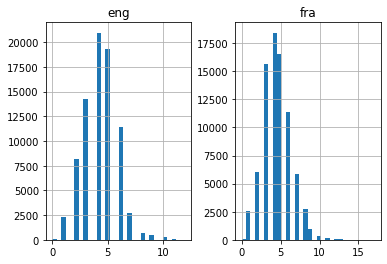

In [17]:
length_df.hist(bins = 30)
plt.show()

In [18]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [19]:
# prepare english tokenizer
eng_tokenizer = tokenization(fra_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 10
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 8374


In [20]:
# prepare French tokenizer
fra_tokenizer = tokenization(fra_eng[:, 1])
fra_vocab_size = len(fra_tokenizer.word_index) + 1

fra_length = 10
print('Deutch Vocabulary Size: %d' % fra_vocab_size)

Deutch Vocabulary Size: 17472


In [21]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [22]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(fra_eng, test_size=0.1, random_state = 12)

In [23]:
print(train.shape)
print(test.shape)

(72605, 2)
(8068, 2)


In [24]:
# prepare training data
trainX = encode_sequences(fra_tokenizer, fra_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [25]:
# prepare validation data
testX = encode_sequences(fra_tokenizer, fra_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [26]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(Bidirectional(LSTM(units, dropout=0.3,recurrent_dropout=0.2)))
    # model.add(LSTM(64, activation='relu', return_sequences=False))
    model.add(RepeatVector(out_timesteps))
    # model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(Bidirectional(LSTM(units, return_sequences=True)))
    model.add(TimeDistributed(Dense(out_vocab, activation='softmax')))
    return model

In [27]:
model = build_model(fra_vocab_size, eng_vocab_size, fra_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 512)           8945664   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1024)              4198400   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 10, 1024)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 10, 1024)          6295552   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 8374)          8583350   
Total params: 28,022,966
Trainable params: 28,022,966
Non-trainable params: 0
_________________________________________________________________


In [28]:
filename = 'model_FrenchToEnglish'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=50, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 58084 samples, validate on 14521 samples
Epoch 1/50
58084/58084 [==============================] - 1103s 19ms/step - loss: 2.9418 - val_loss: 2.5075

Epoch 00001: val_loss improved from inf to 2.50747, saving model to model_FrenchToEnglish
Epoch 2/50
58084/58084 [==============================] - 1097s 19ms/step - loss: 2.2572 - val_loss: 2.0754

Epoch 00002: val_loss improved from 2.50747 to 2.07538, saving model to model_FrenchToEnglish
Epoch 3/50
58084/58084 [==============================] - 1069s 18ms/step - loss: 1.8573 - val_loss: 1.7737

Epoch 00003: val_loss improved from 2.07538 to 1.77369, saving model to model_FrenchToEnglish
Epoch 4/50
58084/58084 [==============================] - 1177s 20ms/step - loss: 1.5691 - val_loss: 1.5603

Epoch 00004: val_loss improved from 1.77369 to 1.56031, saving model to model_FrenchToEnglish
Epoch 5/50
58084/58084 [==============================] - 1082s 19ms/step - loss: 1.3445 - val_loss: 1.3944

Epoch 00005: val_loss improved fr

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [ ]:
model = load_model('model_FrenchToEnglish')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [ ]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [ ]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [ ]:
pred_df = pd.DataFrame({'given' : test[:,1], 'actual' : test[:,0], 'predicted' : preds_text})
pd.set_option('display.max_colwidth', 200)
pred_df.head(15)

In [ ]:
pred_df.tail(15)

### TESTING

In [26]:
d = pd.read_csv('realData/data5.csv', encoding = 'utf-8')
print(d.shape)
d.head(10)
lines = d

(4408, 2)


In [33]:
eng_list = []
fra_list = []
for index, row in  lines.iterrows():
    if len(row) >= 2:
        eng_list.append(row['English'])
        fra_list.append(row['French'])
print(len(eng_list))
len(fra_list)
fra_list

4408


[' Pas de soucis. Mon plaisir.',
 " Merci à l'instant s'il vous plaît",
 ' Vérifiez le crédit de la compagnie aérienne',
 ' Merci pour les détails.',
 " Merci pour l'attente.",
 ' Aucun problème.',
 ' Annuler la réservation',
 ' Sélectionnez la réservation',
 ' Merci.',
 ' Annuler la réservation',
 ' Vérifier le client',
 ' Aucun problème.',
 ' Achraf presque terminé.',
 " Merci pour l'attente.",
 ' Annuler la réservation',
 ' Est-ce que le vol va à Las Vegas?',
 ' Êtes-vous là?',
 ' Salut Jennifer, comment puis-je vous aider?',
 ' Parfait!',
 ' Je suis désolé pour cela, laissez-moi vous aider.',
 ' Je suis ici.',
 ' Au plaisir de vous aider!',
 ' Merci.',
 ' Seul un vol pour Seattle.',
 ' Quel numéro dois-je composer?',
 " C'est correct",
 ' Vous êtes les bienvenus!',
 " J'espère que nous sommes toujours connectés ...",
 ' Comment puis-je vous aider?',
 " Bonjour, comment puis-je vous aider aujourd'hui?",
 ' Merci beaucoup.',
 ' Merci, permettez-moi juste un instant…',
 ' Bonjour.',
 

In [34]:
# Remove punctuation
eng_list = [s.translate(str.maketrans('', '', string.punctuation)) for s in eng_list]
fra_list = [s.translate(str.maketrans('', '', string.punctuation)) for s in fra_list]

In [35]:
# convert to lowercase
for i in range(len(eng_list)):
    eng_list[i] = eng_list[i].lower()
    fra_list[i] = fra_list[i].lower()
    


In [36]:
# fren1 = 'je veux voir ma réservation'
# eng1 = 'I want to see my reservation'
# fren2 = 'annuler ma réservation'
# eng2 = 'cancel my booking'
# fren3 = 'Salut! Comment puis-je vous aider aujourd hui?'
# eng3 = 'Hi! How can I help you today?'
# lines = (fra_list
testZ = encode_sequences(fra_tokenizer, fra_length, fra_list)
# testZ = encode_sequences(fra_tokenizer, fra_length, test[:, 1])

testZ.reshape((testZ.shape[0],testZ.shape[1]))
testZ.shape

(4408, 10)

In [38]:
model = load_model('model_FrenchToEnglish')
# preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))
preds = model.predict_classes(testZ)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [39]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [40]:
pred_df = pd.DataFrame({'given' : fra_list, 'actual' : eng_list, 'predicted' : preds_text})
pd.set_option('display.max_colwidth', 200)

pd.set_option('display.max_columns', None)
pred_df.head(2000)
# print(pred_df)
#pred_df.tail(1000)

,given,actual,predicted
0,pas de soucis mon plaisir,no worries my pleasure,no worries my pleasure
1,merci à linstant sil vous plaît,thank you on moment please,thank you on moment please
2,vérifiez le crédit de la compagnie aérienne,check for airline credit,check for airline credit
3,merci pour les détails,thank you for the details,thank you for the details
4,merci pour lattente,thank you for waiting,thank you for waiting
...,...,...,...
1995,salut je suis encore là,hi there im still here,hi im still here
1996,bonjour voici yara comment puisje aider,hello this is yara how can i help,hello this is yara how can i help
1997,vérifier le client,verify customer,verify customer
1998,annuler la réservation,cancel booking,cancel booking


In [46]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
# pred_df.head(2000)
pd.set_option('display.max_colwidth', 200)
pred_df.head(2000)

,given,actual,predicted
0,pas de soucis mon plaisir,no worries my pleasure,no worries my pleasure
1,merci à linstant sil vous plaît,thank you on moment please,thank you on moment please
2,vérifiez le crédit de la compagnie aérienne,check for airline credit,check for airline credit
3,merci pour les détails,thank you for the details,thank you for the details
4,merci pour lattente,thank you for waiting,thank you for waiting
5,aucun problème,no problem,no problem
6,annuler la réservation,cancel booking,cancel booking
7,sélectionnez la réservation,select booking,select booking
8,merci,thanks,thanks
9,annuler la réservation,cancel booking,cancel booking


In [47]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(pred_df)

In [48]:
# fren1 = 'je veux voir ma réservation'
# eng1 = 'I want to see my reservation'
# fren2 = 'annuler ma réservation'
# eng2 = 'cancel my booking'
# fren3 = 'Salut! Comment puis-je vous aider aujourd hui?'
# eng3 = 'Hi! How can I help you today?'
# lines = (fra_list
testZ = encode_sequences(eng_tokenizer, eng_length, eng_list)
# testZ = encode_sequences(fra_tokenizer, fra_length, test[:, 1])

testZ.reshape((testZ.shape[0],testZ.shape[1]))
testZ.shape

(4408, 10)

In [49]:
model = load_model('model_EnglishTOFrench')
# preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))
preds = model.predict_classes(testZ)

In [50]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], fra_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], fra_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [51]:
pred_df = pd.DataFrame({'given' : eng_list, 'actual' : fra_list, 'predicted' : preds_text})
pd.set_option('display.max_colwidth', 200)

pd.set_option('display.max_columns', None)
pred_df.head(2000)
# print(pred_df)
#pred_df.tail(1000)

,given,actual,predicted
0,no worries my pleasure,pas de soucis mon plaisir,pas de soucis mon plaisir
1,thank you on moment please,merci à linstant sil vous plaît,merci vous remercie un sil vous plaît
2,check for airline credit,vérifiez le crédit de la compagnie aérienne,vérifiez le crédit de la compagnie aérienne
3,thank you for the details,merci pour les détails,merci pour les détails
4,thank you for waiting,merci pour lattente,merci pour lattente
5,no problem,aucun problème,aucun problème
6,cancel booking,annuler la réservation,annuler la réservation
7,select booking,sélectionnez la réservation,sélectionnez la réservation
8,thanks,merci,merci
9,cancel booking,annuler la réservation,annuler la réservation
